In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/MyDrive/6.862_MachineLearningProject/BuildingEnergyConsumption/Code

/content/drive/MyDrive/6.862_MachineLearningProject/BuildingEnergyConsumption/Code


In [3]:
# Imports:
import numpy as np
import pandas as pd
import os
from os.path import join
import glob
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.pyplot import figure
import datetime

from load_and_process_data import process_data
from load_electricity_school_data import load_electricity_education
from feature_encoding_and_data_splitting import split_data, prepare_data_simple_encoding, prepare_data_polynomial_encoding
from linear_regression_functions import learn_parameters, plot_loss_history, plot_test_and_prediction, plot_linear_regression_weights

#import autosklearn
#from autosklearn import *
#import autosklearn.regression
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor



import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

### 1. Import electricity data for buildings with Educational primary use:

In [4]:
# In colab import files like:
datafolder = '../Data/ashrae-energy-prediction/'
pd_all = process_data(datafolder)
# Load all Education buildings Electricity consumption data that has good 
# electricity meter reading values:
#pd_educational = load_electricity_education(pd_all)

In [5]:
pd_educational = pd_all.copy()
pd_educational = pd_educational.loc[(pd_educational["meter"]==0)]
pd_educational = pd_educational.loc[(pd_educational["primary_use"]=='Education')]
# Load all building_ids that have bad meter_reading and remove this data from our DataFrame:
drop_ids = np.loadtxt('dropids.txt')
pd_educational = pd_educational[~pd_educational.building_id.isin(drop_ids)]
# Choose features we care about:
features = ['building_id','square_feet','year_built','floor_count','timestamp','air_temperature','cloud_coverage','dew_temperature',
            'precip_depth_1_hr','sea_level_pressure','wind_direction','wind_speed','meter_reading']
pd_educational = pd_educational[features]

In [6]:
features_norm = ['square_feet','year_built','floor_count','air_temperature','cloud_coverage','dew_temperature',
            'precip_depth_1_hr','sea_level_pressure','wind_direction','wind_speed','meter_reading']
pd_educational[features_norm]

,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,meter_reading
1707550,72102,1970.0,5.0,15.6,6.0,-5.6,0.0,1015.30,270.0,3.6,77.610
1707553,72102,1970.0,5.0,13.9,4.0,-5.6,0.0,1015.60,270.0,4.1,75.830
1707556,72102,1970.0,5.0,13.3,2.0,-5.6,0.0,1016.00,270.0,3.1,80.570
1707559,72102,1970.0,5.0,12.2,0.0,-6.1,0.0,1016.60,280.0,3.1,81.530
1707562,72102,1970.0,5.0,11.7,2.0,-6.7,0.0,1017.00,270.0,3.1,83.550
...,...,...,...,...,...,...,...,...,...,...,...
20068262,30143,1951.0,5.0,3.0,1.0,-8.0,-1.0,1007.55,180.0,5.7,245.675
20068263,30143,1951.0,5.0,2.8,2.0,-8.9,-1.0,1007.40,180.0,7.7,250.125
20068264,30143,1951.0,5.0,2.8,2.0,-7.2,-1.0,1007.50,180.0,5.1,247.875
20068265,30143,1951.0,5.0,2.2,2.0,-6.7,-1.0,1008.00,170.0,4.6,247.575


In [7]:
pd_educational[features_norm] = (pd_educational[features_norm] - pd_educational[features_norm].mean())/pd_educational[features_norm].std()

In [8]:
pd_educational.columns

Index(['building_id', 'square_feet', 'year_built', 'floor_count', 'timestamp',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'meter_reading'],
      dtype='object')

In [9]:
pd_educational

,building_id,square_feet,year_built,floor_count,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,meter_reading
1707550,163,-0.723717,0.246510,-0.195171,2016-01-01 00:00:00,0.002158,0.931130,-1.380284,-0.163951,-0.067111,0.814470,-0.052290,-0.659318
1707553,163,-0.723717,0.246510,-0.195171,2016-01-01 01:00:00,-0.162260,0.182517,-1.380284,-0.163951,-0.025715,0.814470,0.152008,-0.663954
1707556,163,-0.723717,0.246510,-0.195171,2016-01-01 02:00:00,-0.220290,-0.566095,-1.380284,-0.163951,0.029481,0.814470,-0.256587,-0.651609
1707559,163,-0.723717,0.246510,-0.195171,2016-01-01 03:00:00,-0.326678,-1.314708,-1.436521,-0.163951,0.112274,0.906114,-0.256587,-0.649109
1707562,163,-0.723717,0.246510,-0.195171,2016-01-01 04:00:00,-0.375036,-0.566095,-1.504005,-0.163951,0.167469,0.814470,-0.256587,-0.643848
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20068262,1441,-1.196788,-0.437945,-0.195171,2016-12-31 19:00:00,-1.216468,-0.940402,-1.650221,-0.331864,-1.136519,-0.010321,0.805762,-0.221603
20068263,1441,-1.196788,-0.437945,-0.195171,2016-12-31 20:00:00,-1.235811,-0.566095,-1.751448,-0.331864,-1.157217,-0.010321,1.622953,-0.210013
20068264,1441,-1.196788,-0.437945,-0.195171,2016-12-31 21:00:00,-1.235811,-0.566095,-1.560242,-0.331864,-1.143418,-0.010321,0.560604,-0.215873
20068265,1441,-1.196788,-0.437945,-0.195171,2016-12-31 22:00:00,-1.293841,-0.566095,-1.504005,-0.331864,-1.074424,-0.101964,0.356306,-0.216655


In [10]:
pd_educational['timestamp'] = pd.to_numeric(pd.to_datetime(pd_educational.timestamp))

### 2. Prepare dataset for LSTM.

LSTM expects input of form [samples, timesteps, features] and function prepare_for_LSTM shapes input data in this form.

In [10]:
THRES = 8000
test_size = 24*31 - 1
def prepare_for_LSTM(pd, input_features, target):
  features_per_sample_train = []
  features_per_sample_test = []  
  target_per_sample_train = []
  target_per_sample_test = []
  for bldg_id in pd.building_id.unique():
    building = pd[pd.building_id == bldg_id]
    if len(building.timestamp.values) > THRES:
      features_per_sample_train.append(np.array(np.float32(building[input_features][-THRES:-test_size])))
      features_per_sample_test.append(np.array(np.float32(building[input_features][-test_size:])))
      target_per_sample_train.append(np.array(np.float32(building[target][-THRES:-test_size])))
      target_per_sample_test.append(np.array(np.float32(building[target][-test_size:])))
  return (np.stack(features_per_sample_train),np.stack(features_per_sample_test), np.array(target_per_sample_train),np.array(target_per_sample_test))

In [11]:
input_features = ['square_feet','year_built','floor_count','timestamp','air_temperature','cloud_coverage','dew_temperature',
            'precip_depth_1_hr','sea_level_pressure','wind_direction','wind_speed']
target = ['meter_reading']

train_x, test_x, train_y, test_y = prepare_for_LSTM(pd_educational,input_features,target)

In [12]:
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((95, 7257, 11), (95, 743, 11), (95, 7257, 1), (95, 743, 1))

#### Combine training data into dataset for training:

In [17]:
train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y))

### 3. Make model for LSTM:

In [64]:
num_features = train_x.shape[-1]
# Let's first normalize the input:
normalizer = tf.keras.layers.experimental.preprocessing.Normalization()
normalizer.adapt(train_x)
# Let's make a model:
lstm_model = tf.keras.Sequential([
      normalizer,
      tf.keras.layers.LSTM(units=32, # units is the number of hidden states
          input_shape = (None, num_features), # None to allow for flexible prediction length
          #dropout = 0.2, # for regularization
          return_sequences = True) ,
      tf.keras.layers.Dense(1)

])

lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),#5e-4),
              loss=keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.MeanSquaredError()])

In [65]:
lstm_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_6 (Normalizati (None, None, 11)          23        
_________________________________________________________________
lstm_6 (LSTM)                (None, None, 32)          5632      
_________________________________________________________________
dense_6 (Dense)              (None, None, 1)           33        
Total params: 5,688
Trainable params: 5,665
Non-trainable params: 23
_________________________________________________________________


In [66]:
history = lstm_model.fit(train_ds.batch(64), 
          epochs=15, 
          verbose = 1)
          #callbacks=tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3))

Epoch 1/15
2/2 [==============================] - 10s 4s/step - loss: 1.0577 - mean_squared_error: 1.0577
Epoch 2/15
2/2 [==============================] - 9s 4s/step - loss: 0.9845 - mean_squared_error: 0.9845
Epoch 3/15
2/2 [==============================] - 8s 4s/step - loss: 0.7182 - mean_squared_error: 0.7182
Epoch 4/15
2/2 [==============================] - 8s 4s/step - loss: 0.7169 - mean_squared_error: 0.7169
Epoch 5/15
2/2 [==============================] - 8s 4s/step - loss: 0.6890 - mean_squared_error: 0.6890
Epoch 6/15
2/2 [==============================] - 8s 4s/step - loss: 0.6638 - mean_squared_error: 0.6638
Epoch 7/15
2/2 [==============================] - 9s 4s/step - loss: 0.6586 - mean_squared_error: 0.6586
Epoch 8/15
2/2 [==============================] - 8s 4s/step - loss: 0.6388 - mean_squared_error: 0.6388
Epoch 9/15
2/2 [==============================] - 8s 4s/step - loss: 0.6211 - mean_squared_error: 0.6211
Epoch 10/15
2/2 [==============================] - 8s 

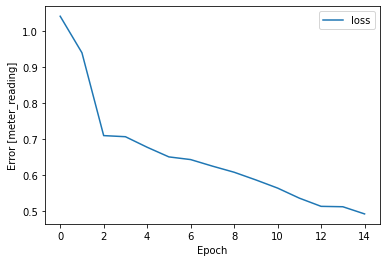

In [67]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error [meter_reading]')
    #plt.ylim((0,500))
    plt.legend()
plot_loss(history)

In [68]:
lstm_model.evaluate(
    test_x,
    test_y, verbose=1)

3/3 [==============================] - 1s 60ms/step - loss: 0.3773 - mean_squared_error: 0.3773


[0.37725359201431274, 0.37725359201431274]

In [69]:
y_hat = lstm_model.predict(test_x)

In [70]:
target_val = np.mean(test_y, axis = 0).T
y_prediction = np.mean(y_hat,axis = 0).T

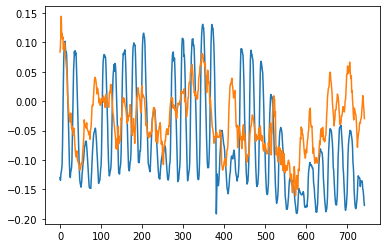

In [71]:
n = np.arange(0,len(target_val),1)
plt.plot(target_val[0])
plt.plot(y_prediction[0])
plt.show()

### 3. Let's prepare data such that we have 7 day memory:

In [11]:
THRES = 8000
test_size = 24*31 - 1
def prepare_for_LSTM_with_memory(pd, input_features, target, days_in = 7):
  days_in_points = days_in*24
  features_per_sample_train = []
  target_per_sample_train = []
  features_per_sample_test = []
  target_per_sample_test = []
  all_features = input_features.copy()
  all_features.extend(target)
  for bldg_id in pd.building_id.unique():
    building = pd[pd.building_id == bldg_id]
    if len(building.timestamp.values) > THRES:
      building = building[-THRES:]
      #building_test = building[-test_size:]
      #building_train = building[-THRES:-test_size]
      features_per_sample = []
      target_per_sample = []
      for i in range(len(building.timestamp)- days_in_points):
        features_per_sample.append(np.array(np.float32(building[all_features][i:i+days_in_points])))
        target_per_sample.append(np.array(np.float32(building[target][i+days_in_points:i+days_in_points+1])))
      features_per_sample_train.extend(features_per_sample[:-test_size])
      features_per_sample_test.extend(features_per_sample[-test_size:])
      target_per_sample_train.extend(target_per_sample[:-test_size])
      target_per_sample_test.extend(target_per_sample[-test_size:])
  #return features_per_sample, target_per_sample
  return (np.stack(features_per_sample_train),np.stack(features_per_sample_test), np.array(target_per_sample_train),np.array(target_per_sample_test))

In [12]:
pd_educational.building_id.unique()

array([ 163,  168,  169,  173,  174,  175,  181,  183,  185,  201,  209,
        211,  212,  217,  219,  221,  223,  224,  229,  259,  261,  266,
        300,  327,  330,  332,  341,  344,  350,  373,  403,  409,  426,
        445,  457,  461,  472,  481,  482,  483,  486,  487,  488,  489,
        493,  501,  542,  562,  568,  572,  573,  574,  579,  589,  593,
        594,  595,  609,  612,  615,  617,  624,  625,  641,  643,  645,
        652,  653,  654,  655,  706,  750,  753,  768,  770,  780,  782,
        784,  785, 1024, 1044, 1046, 1048, 1049, 1051, 1054, 1055, 1056,
       1058, 1064, 1067, 1080, 1099, 1107, 1121, 1126, 1130, 1138, 1156,
       1178, 1181, 1217, 1327, 1328, 1331, 1339, 1344, 1347, 1350, 1361,
       1378, 1380, 1421, 1427, 1432, 1437, 1439, 1441])

In [13]:
#pd_educational_1bld = pd_educational[pd_educational.building_id.isin([163,168])]
pd_educational_1bld = pd_educational[pd_educational.building_id.isin([163])]

In [14]:
pd_educational_1bld

,building_id,square_feet,year_built,floor_count,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,meter_reading
1707550,163,-0.723717,0.24651,-0.195171,1451606400000000000,0.002158,0.931130,-1.380284,-0.163951,-0.067111,0.814470,-0.052290,-0.659318
1707553,163,-0.723717,0.24651,-0.195171,1451610000000000000,-0.162260,0.182517,-1.380284,-0.163951,-0.025715,0.814470,0.152008,-0.663954
1707556,163,-0.723717,0.24651,-0.195171,1451613600000000000,-0.220290,-0.566095,-1.380284,-0.163951,0.029481,0.814470,-0.256587,-0.651609
1707559,163,-0.723717,0.24651,-0.195171,1451617200000000000,-0.326678,-1.314708,-1.436521,-0.163951,0.112274,0.906114,-0.256587,-0.649109
1707562,163,-0.723717,0.24651,-0.195171,1451620800000000000,-0.375036,-0.566095,-1.504005,-0.163951,0.167469,0.814470,-0.256587,-0.643848
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1733881,163,-0.723717,0.24651,-0.195171,1483210800000000000,-0.055872,0.182517,0.498028,-0.163951,-0.467277,0.264610,-0.052290,-0.627362
1733884,163,-0.723717,0.24651,-0.195171,1483214400000000000,0.050516,0.182517,0.374307,-0.163951,-0.563868,0.722827,-0.052290,-0.621554
1733887,163,-0.723717,0.24651,-0.195171,1483218000000000000,0.108546,0.182517,0.306823,-0.163951,-0.632862,0.539540,0.356306,-0.617152
1733890,163,-0.723717,0.24651,-0.195171,1483221600000000000,0.108546,0.931130,0.374307,-0.163951,-0.660460,0.631183,-0.052290,-0.657495


In [15]:
input_features = ['square_feet','year_built','floor_count','air_temperature','cloud_coverage','dew_temperature',
            'precip_depth_1_hr','sea_level_pressure','wind_direction','wind_speed']
target = ['meter_reading']
input_features = ['square_feet','year_built','floor_count']

train_x, test_x, train_y, test_y = prepare_for_LSTM_with_memory(pd_educational,input_features,target,days_in=1)

In [17]:
print(train_x.shape, train_y.shape)

(687135, 24, 4) (687135, 1, 1)


In [18]:
print(test_x.shape, test_y.shape)

(70585, 24, 4) (70585, 1, 1)


In [19]:
train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y))

In [20]:
num_features = train_x.shape[2]
timesteps = train_x.shape[1]
# Let's make a model:
lstm_model = tf.keras.Sequential([
      tf.keras.layers.LSTM(units=50, activation='relu', # units is the number of hidden states
          input_shape = (timesteps, num_features),
          return_sequences = True) ,
      tf.keras.layers.Dense(1)

])

lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),#5e-4),
              loss=keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.MeanSquaredError()])

In [21]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 24, 50)            11000     
_________________________________________________________________
dense (Dense)                (None, 24, 1)             51        
Total params: 11,051
Trainable params: 11,051
Non-trainable params: 0
_________________________________________________________________


In [22]:
history = lstm_model.fit(train_x, train_y, 
                         batch_size = 512,
          epochs=10, 
          verbose = 1)
          #callbacks=tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3))

Epoch 1/10
1343/1343 [==============================] - 37s 25ms/step - loss: 0.4367 - mean_squared_error: 0.4367
Epoch 2/10
1343/1343 [==============================] - 35s 26ms/step - loss: 0.1368 - mean_squared_error: 0.1368
Epoch 3/10
1343/1343 [==============================] - 34s 25ms/step - loss: 0.0936 - mean_squared_error: 0.0936
Epoch 4/10
1343/1343 [==============================] - 34s 25ms/step - loss: 0.0734 - mean_squared_error: 0.0734
Epoch 5/10
1343/1343 [==============================] - 34s 25ms/step - loss: 0.0620 - mean_squared_error: 0.0620
Epoch 6/10
1343/1343 [==============================] - 34s 25ms/step - loss: 0.0535 - mean_squared_error: 0.0535
Epoch 7/10
1343/1343 [==============================] - 34s 26ms/step - loss: 0.0479 - mean_squared_error: 0.0479
Epoch 8/10
1343/1343 [==============================] - 35s 26ms/step - loss: 0.0462 - mean_squared_error: 0.0462
Epoch 9/10
1343/1343 [==============================] - 35s 26ms/step - loss: 0.0432 - m

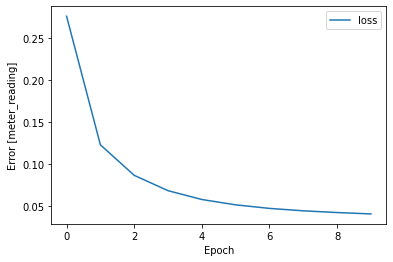

In [23]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error [meter_reading]')
    #plt.ylim((0,500))
    plt.legend()
plot_loss(history)

In [24]:
lstm_model.evaluate(
    test_x,
    test_y, verbose=1)

2206/2206 [==============================] - 8s 4ms/step - loss: 0.0134 - mean_squared_error: 0.0134


[0.01338877622038126, 0.013388793915510178]

In [25]:
y_hat = lstm_model.predict(test_x)

In [26]:
y_hat_last = y_hat[:,0,:]
y_hat_last.shape

(70585, 1)

In [27]:
test_y.shape

(70585, 1, 1)

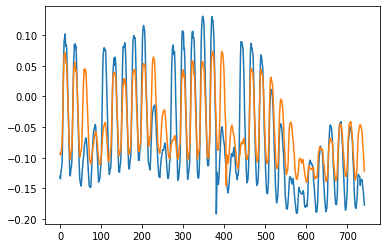

In [28]:
newarr = np.array_split(test_y[:,0,0], 95)
two_blds = np.mean(newarr, axis = 0)
newarrp = np.array_split(y_hat_last[:,0], 95)
two_bldsp = np.mean(newarrp, axis = 0)
n = np.arange(0,len(two_blds),1)
plt.plot(two_blds)
plt.plot(two_bldsp)
#plt.plot(y_prediction[0])
plt.show()

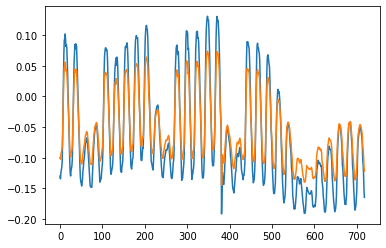

In [29]:
# If we shift predictions on top of each other:
newarr = np.array_split(test_y[:,0,0], 95)
two_blds = np.mean(newarr, axis = 0)
newarrp = np.array_split(y_hat_last[:,0], 95)
two_bldsp = np.mean(newarrp, axis = 0)
n = np.arange(0,len(two_blds),1)
plt.plot(two_blds[:-24])
plt.plot(two_bldsp[24:])
#plt.plot(y_prediction[0])
plt.show()

#### 3.1. Using this solution let's predict 24h in advance given previous 24h data:

In [30]:
test_x.shape

(70585, 24, 4)

In [31]:
yhat = lstm_model.predict(test_x)
yhat[:,0:1,:].shape

(70585, 1, 1)

In [72]:
yhat = []
n_ahead = 24*7

X = test_x.copy()

for _ in range(n_ahead):
  fc = lstm_model.predict(X)
  yhat.append(fc[:,0,0])

  helper_X = X[:,:,3]
  X[:,:-1,3] = helper_X[:,1:]
  # Creating a new input matrix for forecasting
  X[:,-1,3] = fc[:,0,0]


  # Ommiting the first variable
  #X = np.delete(X, 0)

  # Reshaping for the next iteration
  #X = np.reshape(X, (1, len(X), 1))



In [54]:
## different try for 24h ahead prediction:
yhat = []
n_ahead = 24*2

X = test_x.copy()

for _ in range(n_ahead):
  fc = lstm_model.predict(X)
  yhat.append(fc[:,0,0])

  helper_X = X[:,:,3]
  for sample in range(0,X.shape[0],n_ahead):
    for idx in range(23):
      X[sample,idx,3] = helper_X[sample,idx+1]
    X[sample,-1,3] = fc[sample,0,0]
  #X[:,:-1,3] = helper_X[:,1:]
  # Creating a new input matrix for forecasting
 # X[:,-1,3] = fc[:,0,0]

In [73]:
yhat = np.array(yhat)
yhat.shape

(168, 70585)

In [74]:
newarr1 = np.array_split(yhat[:,:], 95, axis = 1)
all_blds = np.mean(newarr1,axis = 0)
print(all_blds.shape)

yhat_tot = []
for i in range(0,all_blds.shape[1],n_ahead):
  #if i%(n_ahead) == 0:
  yhat_tot.extend(all_blds[:,i])

yhat_tot = np.array(yhat_tot)
yhat_tot.shape

(168, 743)


(840,)

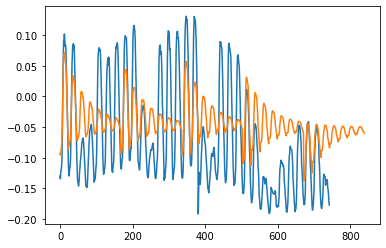

In [75]:
newarr = np.array_split(test_y[:,0,0], 95)
two_blds = np.mean(newarr, axis = 0)
n = np.arange(0,len(two_blds),1)
plt.plot(two_blds)
plt.plot(yhat_tot)
#plt.plot(y_prediction[0])
plt.show()

### 4. LSTM one building no features, just target, last day:

In [163]:
pd_educational_1bld = pd_educational[pd_educational.building_id.isin([163])]
pd_simple = pd_educational_1bld['meter_reading']
THRES = 8000
pd_simple = pd_simple[-THRES:]

In [164]:
X, y = [],[]
lag = 24 # one day
pd_simple_array = pd_simple.values
for i in range(len(pd_simple_array) - lag):
  X.append(pd_simple_array[i:(i+lag)])
  y.append(pd_simple_array[i+lag])

X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))


# split into train and test:
test_size = 24*31 - 1
train_X = X[:-test_size,:,:]
test_X = X[-test_size:,:,:]
train_y = y[:-test_size]
test_y = y[-test_size:]


model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(50, activation='relu', input_shape=(lag, 1)))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss=keras.losses.MeanSquaredError())

model.fit(train_X,train_y, batch_size=64,epochs=10,shuffle=False)

Epoch 1/10
114/114 [==============================] - 4s 27ms/step - loss: 0.0381
Epoch 2/10
114/114 [==============================] - 3s 28ms/step - loss: 0.0015
Epoch 3/10
114/114 [==============================] - 3s 28ms/step - loss: 0.0014
Epoch 4/10
114/114 [==============================] - 3s 27ms/step - loss: 0.0013
Epoch 5/10
114/114 [==============================] - 3s 27ms/step - loss: 0.0011
Epoch 6/10
114/114 [==============================] - 3s 27ms/step - loss: 8.1584e-04
Epoch 7/10
114/114 [==============================] - 3s 27ms/step - loss: 5.8748e-04
Epoch 8/10
114/114 [==============================] - 3s 28ms/step - loss: 4.9344e-04
Epoch 9/10
114/114 [==============================] - 3s 27ms/step - loss: 4.5477e-04
Epoch 10/10
114/114 [==============================] - 3s 27ms/step - loss: 4.2491e-04


In [165]:
yhat = [y[0] for y in model.predict(test_X)]

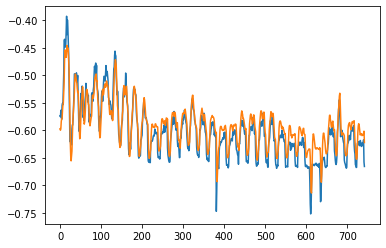

In [166]:
n = np.arange(0,len(yhat),1)
plt.plot(test_y)
plt.plot(yhat)
#plt.plot(y_prediction[0])
plt.show()

### 5. LSTM one building with features, last day:

In [270]:
pd_educational_1bld = pd_educational[pd_educational.building_id.isin([163])]
input_features = ['square_feet','year_built','floor_count','air_temperature','cloud_coverage','dew_temperature',
            'precip_depth_1_hr','sea_level_pressure','wind_direction','wind_speed']
input_features = ['square_feet','year_built','floor_count']
target = ['meter_reading']
pd_simple = pd_educational_1bld[input_features+target]
THRES = 8000
pd_simple = pd_simple[-THRES:]

In [271]:
X, y = [],[]
lag = 24 # one day
pd_simple_array = pd_simple.values
for i in range(pd_simple_array.shape[0] - lag):
  X.append(pd_simple_array[i:(i+lag)])
  y.append(pd_simple[target].values[i+lag])

X, y = np.array(X), np.array(y)

# split into train and test:
test_size = 24*31 - 1
train_X = X[:-test_size,:,:]
test_X = X[-test_size:,:,:]
train_y = y[:-test_size]
test_y = y[-test_size:]

# June
# train_X = np.concatenate((X[:6*30*24,:,:], X[6*30*24+test_size:,:,:]))
# test_X = X[6*30*24:6*30*24+test_size:,:,:]
# train_y = np.concatenate((y[:6*30*24,:], y[6*30*24+test_size:,:]))
# test_y = y[6*30*24:6*30*24+test_size:,:]

model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(50, activation='relu', input_shape=(X.shape[1], X.shape[2])))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss=keras.losses.MeanSquaredError())

model.fit(train_X,train_y, batch_size=64,epochs=15,shuffle=False)

Epoch 1/15
114/114 [==============================] - 4s 27ms/step - loss: 0.0549
Epoch 2/15
114/114 [==============================] - 3s 28ms/step - loss: 0.0024
Epoch 3/15
114/114 [==============================] - 3s 27ms/step - loss: 0.0023
Epoch 4/15
114/114 [==============================] - 3s 27ms/step - loss: 0.0021
Epoch 5/15
114/114 [==============================] - 3s 27ms/step - loss: 0.0017
Epoch 6/15
114/114 [==============================] - 3s 27ms/step - loss: 0.0014
Epoch 7/15
114/114 [==============================] - 3s 27ms/step - loss: 0.0011
Epoch 8/15
114/114 [==============================] - 3s 27ms/step - loss: 8.8157e-04
Epoch 9/15
114/114 [==============================] - 3s 27ms/step - loss: 6.7441e-04
Epoch 10/15
114/114 [==============================] - 3s 27ms/step - loss: 5.9923e-04
Epoch 11/15
114/114 [==============================] - 3s 27ms/step - loss: 5.4851e-04
Epoch 12/15
114/114 [==============================] - 3s 27ms/step - loss: 5.11

In [272]:
yhat = [y[0] for y in model.predict(test_X)]

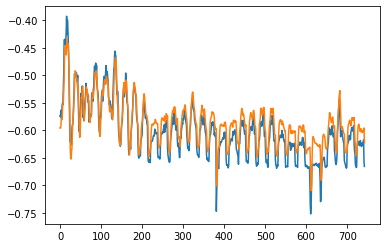

In [273]:
n = np.arange(0,len(yhat),1)
plt.plot(test_y)
plt.plot(yhat)
#plt.plot(y_prediction[0])
plt.show()

### 6. LSTM five buildings with features, last day:

In [285]:
pd_educational_5bld = pd_educational[pd_educational.building_id.isin(pd_educational.building_id.unique()[:5])]
input_features = ['square_feet','year_built','floor_count','air_temperature','cloud_coverage','dew_temperature',
            'precip_depth_1_hr','sea_level_pressure','wind_direction','wind_speed']
input_features = ['building_id','square_feet','year_built','floor_count']
target = ['meter_reading']
pd_5bld = pd_educational_5bld[input_features+target]

In [286]:
pd_5bld

,building_id,square_feet,year_built,floor_count,meter_reading
1707550,163,-0.723717,0.246510,-0.195171,-0.659318
1707553,163,-0.723717,0.246510,-0.195171,-0.663954
1707556,163,-0.723717,0.246510,-0.195171,-0.651609
1707559,163,-0.723717,0.246510,-0.195171,-0.649109
1707562,163,-0.723717,0.246510,-0.195171,-0.643848
...,...,...,...,...,...
1953277,174,-0.511777,-0.005658,-0.195171,-0.450572
1953279,174,-0.511777,-0.005658,-0.195171,-0.450182
1953281,174,-0.511777,-0.005658,-0.195171,-0.447603
1953283,174,-0.511777,-0.005658,-0.195171,-0.453854


In [297]:
THRES = 8000
lag = 24 # one day
test_size = 24*31 - 1

train_X = []
test_X = []
train_y = []
test_y = []

for i in pd_5bld.building_id.unique():
  building = pd_5bld[pd_5bld.building_id == i]
  if len(building.meter_reading.values) > THRES:
    building = building[-THRES:]
    building.pop('building_id')
  X, y = [],[]
  pd_simple_array = building.values
  for i in range(pd_simple_array.shape[0] - lag):
    X.append(pd_simple_array[i:(i+lag)])
    y.append(pd_simple[target].values[i+lag])
  # split into train and test:
  X, y = np.array(X), np.array(y)
  train_X.extend(X[:-test_size,:,:])
  test_X.extend(X[-test_size:,:,:])
  train_y.extend(y[:-test_size])
  test_y.extend(y[-test_size:])
train_X,test_X,train_y,test_y = np.array(train_X), np.array(test_X), np.array(train_y), np.array(test_y)

In [298]:
print(train_X.shape, train_y.shape)

(36165, 24, 4) (36165, 1)


In [299]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(50, activation='relu', input_shape=(X.shape[1], X.shape[2])))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss=keras.losses.MeanSquaredError())

model.fit(train_X,train_y, batch_size=64,epochs=10,shuffle=False)

Epoch 1/15
566/566 [==============================] - 16s 27ms/step - loss: 0.0469
Epoch 2/15
566/566 [==============================] - 15s 27ms/step - loss: 0.0030
Epoch 3/15
566/566 [==============================] - 15s 27ms/step - loss: 0.0029
Epoch 4/15
566/566 [==============================] - 15s 27ms/step - loss: 0.0028
Epoch 5/15
566/566 [==============================] - 15s 27ms/step - loss: 0.0028
Epoch 6/15
566/566 [==============================] - 15s 27ms/step - loss: 0.0028
Epoch 7/15
566/566 [==============================] - 15s 27ms/step - loss: 0.0028
Epoch 8/15
566/566 [==============================] - 15s 27ms/step - loss: 0.0029
Epoch 9/15
566/566 [==============================] - 15s 27ms/step - loss: 0.0029
Epoch 10/15
566/566 [==============================] - 15s 27ms/step - loss: 0.0029
Epoch 11/15
566/566 [==============================] - 15s 27ms/step - loss: 0.0029
Epoch 12/15
566/566 [==============================] - 15s 27ms/step - loss: 0.0029
E

In [309]:
yhat = [y[-1] for y in model.predict(test_X)]

In [310]:
np.shape(yhat)

(3715,)

In [311]:
test_y.shape

(3715, 1)

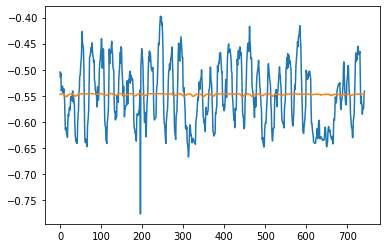

In [314]:
newarr = np.array_split(test_y[:,0], 5)
two_blds = np.mean(newarr, axis = 0)
newarrp = np.array_split(yhat[:], 5)
two_bldsp = np.mean(newarrp,axis = 0)
n = np.arange(0,len(two_blds),1)
plt.plot(two_blds)
plt.plot(two_bldsp)
#plt.plot(y_prediction[0])
plt.show()

### 7. LSTM with all buidlings and input features but with no target data as input:

In [475]:
THRES = 8000
test_size = 24*31 - 1
def prepare_for_LSTM_with_memory_no_target(pd, input_features, target, days_in = 1):
  days_in_points = days_in*24
  features_per_sample_train = []
  target_per_sample_train = []
  features_per_sample_test = []
  target_per_sample_test = []
  for bldg_id in pd.building_id.unique():
    building = pd[pd.building_id == bldg_id]
    if len(building.timestamp.values) > THRES:
      building = building[-THRES:]
      features_per_sample = []
      target_per_sample = []
      for i in range(len(building.timestamp)- days_in_points):
        features_per_sample.append(np.array(np.float32(building[input_features][i:i+days_in_points])))
        target_per_sample.append(np.array(np.float32(building[target][i+days_in_points:i+days_in_points+1])))
      features_per_sample_train.extend(features_per_sample[:-test_size])
      features_per_sample_test.extend(features_per_sample[-test_size:])
      target_per_sample_train.extend(target_per_sample[:-test_size])
      target_per_sample_test.extend(target_per_sample[-test_size:])
  #return features_per_sample, target_per_sample
  return (np.stack(features_per_sample_train),np.stack(features_per_sample_test), np.array(target_per_sample_train),np.array(target_per_sample_test))

In [476]:
pd_educational_1bld = pd_educational[pd_educational.building_id == 163]

In [499]:
input_features = ['square_feet','year_built','floor_count','air_temperature','cloud_coverage','dew_temperature',
            'precip_depth_1_hr','sea_level_pressure','wind_direction','wind_speed']
target = ['meter_reading']

train_x, test_x, train_y, test_y = prepare_for_LSTM_with_memory_no_target(pd_educational_1bld, input_features, target, days_in = 1)

In [527]:
num_features = train_x.shape[-1]
# Let's first normalize the input:
normalizer = tf.keras.layers.experimental.preprocessing.Normalization()
normalizer.adapt(train_x)
# Let's make a model:
lstm_model = tf.keras.Sequential([
      normalizer,
      tf.keras.layers.LSTM(units=24, # units is the number of hidden states
          input_shape = (train_x.shape[1], train_x.shape[-1]), # None to allow for flexible prediction length
          #dropout = 0.2, # for regularization
          return_sequences = True) ,
      tf.keras.layers.Dense(1)

])

lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),#5e-4),
              loss=keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.MeanSquaredError()])

In [528]:
lstm_model.summary()

Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_13 (Normalizat (None, None, 10)          21        
_________________________________________________________________
lstm_66 (LSTM)               (None, None, 24)          3360      
_________________________________________________________________
dense_66 (Dense)             (None, None, 1)           25        
Total params: 3,406
Trainable params: 3,385
Non-trainable params: 21
_________________________________________________________________


In [529]:
train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y))

In [530]:
history = lstm_model.fit(train_ds.batch(128), 
          epochs=15, 
          verbose = 1,
          callbacks=tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3))

Epoch 1/15
57/57 [==============================] - 2s 3ms/step - loss: 0.1393 - mean_squared_error: 0.1393
Epoch 2/15
57/57 [==============================] - 0s 4ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 3/15
57/57 [==============================] - 0s 3ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 4/15
57/57 [==============================] - 0s 3ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 5/15
57/57 [==============================] - 0s 3ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 6/15
57/57 [==============================] - 0s 3ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 7/15
57/57 [==============================] - 0s 3ms/step - loss: 0.0048 - mean_squared_error: 0.0048


In [531]:
lstm_model.evaluate(
    test_x,
    test_y, verbose=1)

24/24 [==============================] - 0s 2ms/step - loss: 0.0080 - mean_squared_error: 0.0080


[0.00803216453641653, 0.008032165467739105]

In [532]:
y_hat = lstm_model.predict(test_x)

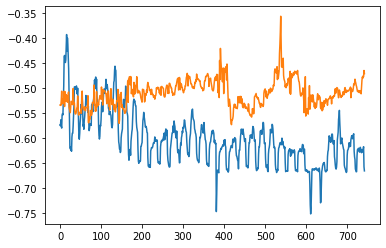

In [533]:
n = np.arange(0,len(test_y),1)
plt.plot(test_y[:,0,0])
plt.plot(y_hat[:,0,0])
plt.show()

### 8. LSTM with all buildings, some features and CNN-LSTM layers:

In [11]:
THRES = 8000
test_size = 24*31 - 1
def prepare_for_LSTM_with_memory_no_target(pd, input_features, target, days_in = 1):
  days_in_points = days_in*24
  features_per_sample_train = []
  target_per_sample_train = []
  features_per_sample_test = []
  target_per_sample_test = []
  for bldg_id in pd.building_id.unique():
    building = pd[pd.building_id == bldg_id]
    if len(building.timestamp.values) > THRES:
      building = building[-THRES:]
      features_per_sample = []
      target_per_sample = []
      for i in range(len(building.timestamp)- days_in_points):
        features_per_sample.append(np.array(np.float32(building[input_features][i:i+days_in_points])))
        target_per_sample.append(np.array(np.float32(building[target][i+days_in_points:i+days_in_points+1])))
      features_per_sample_train.extend(features_per_sample[:-test_size])
      features_per_sample_test.extend(features_per_sample[-test_size:])
      target_per_sample_train.extend(target_per_sample[:-test_size])
      target_per_sample_test.extend(target_per_sample[-test_size:])
  #return features_per_sample, target_per_sample
  return (np.stack(features_per_sample_train),np.stack(features_per_sample_test), np.array(target_per_sample_train),np.array(target_per_sample_test))

In [54]:
input_features = ['square_feet','year_built','floor_count','air_temperature','cloud_coverage','dew_temperature',
            'precip_depth_1_hr','sea_level_pressure','wind_direction','wind_speed']

input_features = ['square_feet','year_built','floor_count','air_temperature','cloud_coverage','dew_temperature',
            'precip_depth_1_hr','sea_level_pressure','wind_direction','wind_speed', 'month','day','weekday','hour']

target = ['meter_reading']
#input_features = ['square_feet','year_built','floor_count']

train_x, test_x, train_y, test_y = prepare_for_LSTM_with_memory(pd_educational,input_features,target,days_in=1)

In [55]:
train_x.shape, train_y.shape

((687135, 24, 15), (687135, 1, 1))

In [56]:
num_features = train_x.shape[2]
timesteps = train_x.shape[1]
# Let's make a model:
lstm_model = tf.keras.Sequential([
      tf.keras.layers.LSTM(units=50, activation='relu', # units is the number of hidden states
          input_shape = (timesteps, num_features),
          dropout = 0.2,
          return_sequences = True) ,
      tf.keras.layers.LSTM(units=50, activation='relu',
          dropout = 0.2,
          return_sequences = True) ,
      tf.keras.layers.LSTM(units=50, activation='relu',
          dropout = 0.2,
          return_sequences = True) ,
      tf.keras.layers.Dense(1)

])

lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),#5e-4),
              loss=keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.MeanSquaredError()])

In [57]:
n_features = train_x.shape[2]
n_timesteps = train_x.shape[1]
n_outputs = train_y.shape[1]
  
cnn_rnn_model = tf.keras.Sequential()
cnn_rnn_model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
cnn_rnn_model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
cnn_rnn_model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
cnn_rnn_model.add(tf.keras.layers.Flatten())
cnn_rnn_model.add(tf.keras.layers.RepeatVector(n_outputs))
cnn_rnn_model.add(tf.keras.layers.LSTM(200, activation='relu', return_sequences=True))
cnn_rnn_model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(100, activation='relu')))
cnn_rnn_model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1)))

cnn_rnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),#5e-4),
              loss=keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.MeanSquaredError()])

In [58]:
cnn_rnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 22, 64)            2944      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 20, 64)            12352     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 10, 64)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 640)               0         
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 1, 640)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 1, 200)            672800    
_________________________________________________________________
time_distributed_4 (TimeDist (None, 1, 100)           

In [59]:
history = cnn_rnn_model.fit(train_x, train_y, 
                         batch_size = 512,
          epochs=10, 
          verbose = 1,
          callbacks=tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3))

Epoch 1/10
1343/1343 [==============================] - 10s 6ms/step - loss: 0.2085 - mean_squared_error: 0.2085
Epoch 2/10
1343/1343 [==============================] - 8s 6ms/step - loss: 0.0262 - mean_squared_error: 0.0262
Epoch 3/10
1343/1343 [==============================] - 8s 6ms/step - loss: 0.0201 - mean_squared_error: 0.0201
Epoch 4/10
1343/1343 [==============================] - 8s 6ms/step - loss: 0.0179 - mean_squared_error: 0.0179
Epoch 5/10
1343/1343 [==============================] - 8s 6ms/step - loss: 0.0160 - mean_squared_error: 0.0160
Epoch 6/10
1343/1343 [==============================] - 8s 6ms/step - loss: 0.0141 - mean_squared_error: 0.0141
Epoch 7/10
1343/1343 [==============================] - 8s 6ms/step - loss: 0.0127 - mean_squared_error: 0.0127
Epoch 8/10
1343/1343 [==============================] - 8s 6ms/step - loss: 0.0129 - mean_squared_error: 0.0129
Epoch 9/10
1343/1343 [==============================] - 8s 6ms/step - loss: 0.0121 - mean_squared_error

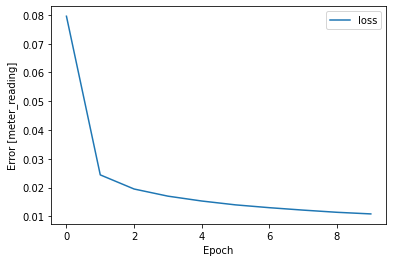

In [60]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error [meter_reading]')
    #plt.ylim((0,500))
    plt.legend()
plot_loss(history)

In [61]:
cnn_rnn_model.evaluate(
    test_x,
    test_y, verbose=1)

2206/2206 [==============================] - 5s 2ms/step - loss: 0.0069 - mean_squared_error: 0.0069


[0.0069084782153368, 0.0069084782153368]

In [62]:
y_hat = cnn_rnn_model.predict(test_x)
y_hat.shape

(70585, 1, 1)

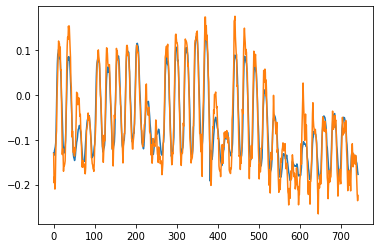

In [63]:
y_hat_last = y_hat[:,0,:]
y_hat_last.shape

newarr = np.array_split(test_y[:,0,0], 95)
two_blds = np.mean(newarr, axis = 0)
newarrp = np.array_split(y_hat_last[:,0], 95)
two_bldsp = np.mean(newarrp, axis = 0)
n = np.arange(0,len(two_blds),1)
plt.plot(two_blds)
plt.plot(two_bldsp)
#plt.plot(y_prediction[0])
plt.show()

In [64]:
a = cnn_rnn_model.predict(test_x)
a.shape

(70585, 1, 1)

In [69]:
## different try for 24h ahead prediction:
yhat = []
n_ahead = 12

X = test_x.copy()

for _ in range(n_ahead):
  fc = cnn_rnn_model.predict(X)
  yhat.append(fc[:,0,0])

  helper_X = X[:,:,3]
  for sample in range(0,X.shape[0],n_ahead):
    for idx in range(23):
      X[sample,idx,3] = helper_X[sample,idx+1]
    X[sample,-1,3] = fc[sample,0,0]
  #X[:,:-1,3] = helper_X[:,1:]
  # Creating a new input matrix for forecasting
 # X[:,-1,3] = fc[:,0,0]

In [70]:
yhat = np.array(yhat)
yhat.shape

(12, 70585)

In [71]:
newarr1 = np.array_split(yhat[:,:], 95, axis = 1)
all_blds = np.mean(newarr1,axis = 0)
print(all_blds.shape)

yhat_tot = []
for i in range(0,all_blds.shape[1],n_ahead):
  #if i%(n_ahead) == 0:
  yhat_tot.extend(all_blds[:,i])

yhat_tot = np.array(yhat_tot)
yhat_tot.shape

(12, 743)


(744,)

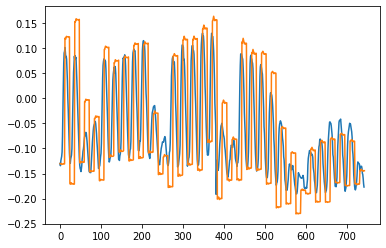

In [72]:
newarr = np.array_split(test_y[:,0,0], 95)
two_blds = np.mean(newarr, axis = 0)
n = np.arange(0,len(two_blds),1)
plt.plot(two_blds)
plt.plot(yhat_tot)
#plt.plot(y_prediction[0])
plt.show()

### 9. Let's add hour, day of the week, day of the month and month number as input features:

In [16]:
pd_educational = pd_all.copy()
pd_educational = pd_educational.loc[(pd_educational["meter"]==0)]
pd_educational = pd_educational.loc[(pd_educational["primary_use"]=='Education')]
# Load all building_ids that have bad meter_reading and remove this data from our DataFrame:
drop_ids = np.loadtxt('dropids.txt')
pd_educational = pd_educational[~pd_educational.building_id.isin(drop_ids)]
# Choose features we care about:
features = ['building_id','square_feet','year_built','floor_count','timestamp','air_temperature','cloud_coverage','dew_temperature',
            'precip_depth_1_hr','sea_level_pressure','wind_direction','wind_speed','meter_reading']
pd_educational = pd_educational[features]

In [17]:
pd_educational['month'] = pd.to_datetime(pd_educational["timestamp"]).dt.month
pd_educational['day'] = pd.to_datetime(pd_educational["timestamp"]).dt.day
pd_educational['weekday'] = pd.to_datetime(pd_educational["timestamp"]).dt.weekday
pd_educational['hour'] = pd.to_datetime(pd_educational["timestamp"]).dt.hour

#### 9.1. Let's normalize this data with just training data mean:

In [18]:
features_norm = ['square_feet','year_built','floor_count','air_temperature','cloud_coverage','dew_temperature',
            'precip_depth_1_hr','sea_level_pressure','wind_direction','wind_speed','meter_reading', 'month','day','weekday','hour']
pd_help = pd_educational.copy()
pd_train = pd_help.loc[pd.to_datetime(pd_help["timestamp"]) < datetime.datetime(2016, 12, 1)]
train_mean = pd_train[features_norm].mean()
train_std = pd_train[features_norm].std()

pd_educational[features_norm] = (pd_educational[features_norm] - train_mean)/train_std

In [19]:
pd_educational

,building_id,square_feet,year_built,floor_count,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,meter_reading,month,day,weekday,hour
1707550,163,-0.724977,0.247395,-0.195586,2016-01-01 00:00:00,-0.083875,0.942712,-1.481647,-0.164421,-0.015770,0.811822,-0.057633,-0.657596,-1.611912,-1.669272,0.498550,-1.662300
1707553,163,-0.724977,0.247395,-0.195586,2016-01-01 01:00:00,-0.252080,0.191372,-1.481647,-0.164421,0.026575,0.811822,0.147224,-0.662185,-1.611912,-1.669272,0.498550,-1.517923
1707556,163,-0.724977,0.247395,-0.195586,2016-01-01 02:00:00,-0.311447,-0.559967,-1.481647,-0.164421,0.083034,0.811822,-0.262490,-0.649965,-1.611912,-1.669272,0.498550,-1.373546
1707559,163,-0.724977,0.247395,-0.195586,2016-01-01 03:00:00,-0.420285,-1.311307,-1.539028,-0.164421,0.167724,0.903407,-0.262490,-0.647491,-1.611912,-1.669272,0.498550,-1.229169
1707562,163,-0.724977,0.247395,-0.195586,2016-01-01 04:00:00,-0.469758,-0.559967,-1.607884,-0.164421,0.224184,0.811822,-0.262490,-0.642283,-1.611912,-1.669272,0.498550,-1.084792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20068262,1441,-1.198335,-0.437384,-0.195586,2016-12-31 19:00:00,-1.330573,-0.935637,-1.757074,-0.329656,-1.109678,-0.012445,0.802766,-0.224340,1.883057,1.733515,0.997909,1.080864
20068263,1441,-1.198335,-0.437384,-0.195586,2016-12-31 20:00:00,-1.350362,-0.559967,-1.860359,-0.329656,-1.130851,-0.012445,1.622195,-0.212868,1.883057,1.733515,0.997909,1.225241
20068264,1441,-1.198335,-0.437384,-0.195586,2016-12-31 21:00:00,-1.350362,-0.559967,-1.665265,-0.329656,-1.116736,-0.012445,0.556938,-0.218669,1.883057,1.733515,0.997909,1.369618
20068265,1441,-1.198335,-0.437384,-0.195586,2016-12-31 22:00:00,-1.409729,-0.559967,-1.607884,-0.329656,-1.046161,-0.104031,0.352081,-0.219442,1.883057,1.733515,0.997909,1.513995


In [20]:
pd_1bld = pd_educational[pd_educational.building_id == 163]

#### 9.2. Let's make a new input learning:

In [21]:
pd_1bld

,building_id,square_feet,year_built,floor_count,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,meter_reading,month,day,weekday,hour
1707550,163,-0.724977,0.247395,-0.195586,2016-01-01 00:00:00,-0.083875,0.942712,-1.481647,-0.164421,-0.015770,0.811822,-0.057633,-0.657596,-1.611912,-1.669272,0.498550,-1.662300
1707553,163,-0.724977,0.247395,-0.195586,2016-01-01 01:00:00,-0.252080,0.191372,-1.481647,-0.164421,0.026575,0.811822,0.147224,-0.662185,-1.611912,-1.669272,0.498550,-1.517923
1707556,163,-0.724977,0.247395,-0.195586,2016-01-01 02:00:00,-0.311447,-0.559967,-1.481647,-0.164421,0.083034,0.811822,-0.262490,-0.649965,-1.611912,-1.669272,0.498550,-1.373546
1707559,163,-0.724977,0.247395,-0.195586,2016-01-01 03:00:00,-0.420285,-1.311307,-1.539028,-0.164421,0.167724,0.903407,-0.262490,-0.647491,-1.611912,-1.669272,0.498550,-1.229169
1707562,163,-0.724977,0.247395,-0.195586,2016-01-01 04:00:00,-0.469758,-0.559967,-1.607884,-0.164421,0.224184,0.811822,-0.262490,-0.642283,-1.611912,-1.669272,0.498550,-1.084792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1733881,163,-0.724977,0.247395,-0.195586,2016-12-31 19:00:00,-0.143241,0.191372,0.434865,-0.164421,-0.425104,0.262310,-0.057633,-0.625965,1.883057,1.733515,0.997909,1.080864
1733884,163,-0.724977,0.247395,-0.195586,2016-12-31 20:00:00,-0.034402,0.191372,0.308627,-0.164421,-0.523908,0.720237,-0.057633,-0.620216,1.883057,1.733515,0.997909,1.225241
1733887,163,-0.724977,0.247395,-0.195586,2016-12-31 21:00:00,0.024964,0.191372,0.239771,-0.164421,-0.594483,0.537066,0.352081,-0.615860,1.883057,1.733515,0.997909,1.369618
1733890,163,-0.724977,0.247395,-0.195586,2016-12-31 22:00:00,0.024964,0.942712,0.308627,-0.164421,-0.622713,0.628652,-0.057633,-0.655792,1.883057,1.733515,0.997909,1.513995


In [25]:
THRES = 8000
test_size = 24*31 - 1
def prepare_for_LSTM_with_timestamp_feat(pd, input_features, target, in_points):
  days_in_points = in_points
  features_per_sample_train = []
  features_per_sample_test = []  
  target_per_sample_train = []
  target_per_sample_test = []
  building = pd
  if len(building.timestamp.values) > THRES:
    building = building[-THRES:]
    features_per_sample = []
    target_per_sample = []
    for i in range(len(building.timestamp)- days_in_points):
      features_per_sample.append(np.array(np.float32(building[input_features][i:i+days_in_points])))
      target_per_sample.append(np.array(np.float32(building[target][i+days_in_points:i+days_in_points+1])))
    features_per_sample_train.extend(features_per_sample[:-test_size])
    features_per_sample_test.extend(features_per_sample[-test_size:])
    target_per_sample_train.extend(target_per_sample[:-test_size])
    target_per_sample_test.extend(target_per_sample[-test_size:])
  return (np.stack(features_per_sample_train),np.stack(features_per_sample_test), np.array(target_per_sample_train),np.array(target_per_sample_test))

In [115]:
input_features = ['square_feet','year_built','floor_count','air_temperature','cloud_coverage','dew_temperature',
            'precip_depth_1_hr','sea_level_pressure','wind_direction','wind_speed']

target = ['meter_reading']

train_x, test_x, train_y, test_y = prepare_for_LSTM_with_timestamp_feat(pd_1bld,input_features,target,in_points = 7*24)

In [116]:
train_x.shape

(7089, 168, 10)

In [117]:
num_features = train_x.shape[2]
timesteps = train_x.shape[1]
# Let's make a model:
lstm_model = tf.keras.Sequential([
      tf.keras.layers.LSTM(units=50, activation='relu', # units is the number of hidden states
          input_shape = (timesteps, num_features),
          dropout = 0.2,
          return_sequences = True) ,
      tf.keras.layers.LSTM(units=50, activation='relu',
          dropout = 0.2,
          return_sequences = True) ,
      tf.keras.layers.Dense(1)

])

lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),#5e-4),
              loss=keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.MeanSquaredError()])

In [118]:
lstm_model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 168, 50)           12200     
_________________________________________________________________
lstm_19 (LSTM)               (None, 168, 50)           20200     
_________________________________________________________________
dense_15 (Dense)             (None, 168, 1)            51        
Total params: 32,451
Trainable params: 32,451
Non-trainable params: 0
_________________________________________________________________


In [119]:
history = lstm_model.fit(train_x, train_y, 
                         batch_size = 512,
          epochs=20, 
          verbose = 1,
          callbacks=tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3))

Epoch 1/20
14/14 [==============================] - 10s 529ms/step - loss: 0.1137 - mean_squared_error: 0.1137
Epoch 2/20
14/14 [==============================] - 7s 526ms/step - loss: 0.0205 - mean_squared_error: 0.0205
Epoch 3/20
14/14 [==============================] - 7s 527ms/step - loss: 0.0130 - mean_squared_error: 0.0130
Epoch 4/20
14/14 [==============================] - 7s 521ms/step - loss: 0.0106 - mean_squared_error: 0.0106
Epoch 5/20
14/14 [==============================] - 7s 522ms/step - loss: 0.0092 - mean_squared_error: 0.0092
Epoch 6/20
14/14 [==============================] - 7s 526ms/step - loss: 0.0083 - mean_squared_error: 0.0083
Epoch 7/20
14/14 [==============================] - 7s 527ms/step - loss: 0.0076 - mean_squared_error: 0.0076
Epoch 8/20
14/14 [==============================] - 7s 524ms/step - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 9/20
14/14 [==============================] - 7s 524ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 10/

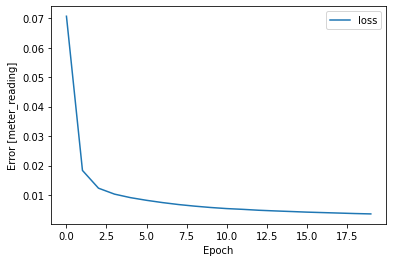

In [120]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error [meter_reading]')
    #plt.ylim((0,500))
    plt.legend()
plot_loss(history)

In [121]:
lstm_model.evaluate(
    test_x,
    test_y, verbose=1)

24/24 [==============================] - 1s 39ms/step - loss: 0.0063 - mean_squared_error: 0.0063


[0.006275160238146782, 0.006275160238146782]

In [122]:
y_hat = lstm_model.predict(test_x)
y_hat.shape

(743, 168, 1)

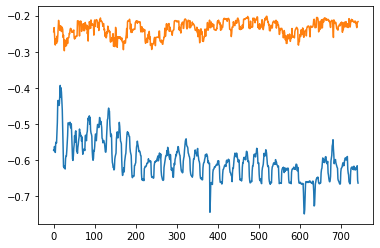

In [123]:
y_hat_last = y_hat[:,0,:]
y_hat_last.shape

newarr = np.array_split(test_y[:,0,0], 1)
two_blds = np.mean(newarr, axis = 0)
newarrp = np.array_split(y_hat_last[:,0], 1)
two_bldsp = np.mean(newarrp, axis = 0)
n = np.arange(0,len(two_blds),1)
plt.plot(two_blds)
plt.plot(two_bldsp)
#plt.plot(y_prediction[0])
plt.show()

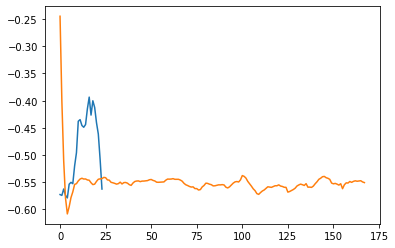

In [124]:
plt.plot(test_y[:24,0,0])
plt.plot(y_hat[0,:,0])
plt.show()

In [125]:
n_features = train_x.shape[2]
n_timesteps = train_x.shape[1]
n_outputs = train_y.shape[1]
  
cnn_rnn_model = tf.keras.Sequential()
cnn_rnn_model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
cnn_rnn_model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
cnn_rnn_model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
cnn_rnn_model.add(tf.keras.layers.Flatten())
cnn_rnn_model.add(tf.keras.layers.RepeatVector(n_outputs))
cnn_rnn_model.add(tf.keras.layers.LSTM(200, activation='relu', return_sequences=True))
cnn_rnn_model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(100, activation='relu')))
cnn_rnn_model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1)))

cnn_rnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),#5e-4),
              loss=keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.MeanSquaredError()])

In [126]:
cnn_rnn_model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 166, 64)           1984      
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 164, 64)           12352     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 82, 64)            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 5248)              0         
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 1, 5248)           0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 1, 200)            4359200   
_________________________________________________________________
time_distributed_8 (TimeDist (None, 1, 100)          

In [127]:
history = cnn_rnn_model.fit(train_x, train_y, 
                         batch_size = 512,
          epochs=20, 
          verbose = 1,
          callbacks=tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3))

Epoch 1/20
14/14 [==============================] - 1s 13ms/step - loss: 0.1648 - mean_squared_error: 0.1648
Epoch 2/20
14/14 [==============================] - 0s 10ms/step - loss: 0.0193 - mean_squared_error: 0.0193
Epoch 3/20
14/14 [==============================] - 0s 10ms/step - loss: 0.0074 - mean_squared_error: 0.0074
Epoch 4/20
14/14 [==============================] - 0s 10ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 5/20
14/14 [==============================] - 0s 9ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 6/20
14/14 [==============================] - 0s 10ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 7/20
14/14 [==============================] - 0s 10ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 8/20
14/14 [==============================] - 0s 10ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 9/20
14/14 [==============================] - 0s 10ms/step - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 10/20
14/14 [=

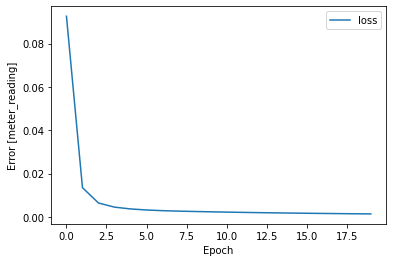

In [128]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error [meter_reading]')
    #plt.ylim((0,500))
    plt.legend()
plot_loss(history)

In [129]:
cnn_rnn_model.evaluate(
    test_x,
    test_y, verbose=1)

24/24 [==============================] - 0s 4ms/step - loss: 0.0103 - mean_squared_error: 0.0103


[0.010307319462299347, 0.010307319462299347]

In [130]:
y_hat = lstm_model.predict(test_x)
y_hat.shape

(743, 168, 1)

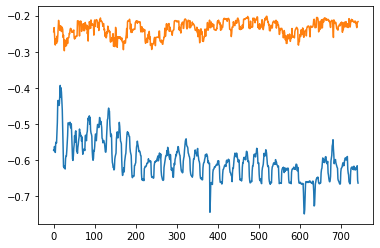

In [131]:
y_hat_last = y_hat[:,0,:]
y_hat_last.shape

newarr = np.array_split(test_y[:,0,0], 1)
two_blds = np.mean(newarr, axis = 0)
newarrp = np.array_split(y_hat_last[:,0], 1)
two_bldsp = np.mean(newarrp, axis = 0)
n = np.arange(0,len(two_blds),1)
plt.plot(two_blds)
plt.plot(two_bldsp)
#plt.plot(y_prediction[0])
plt.show()

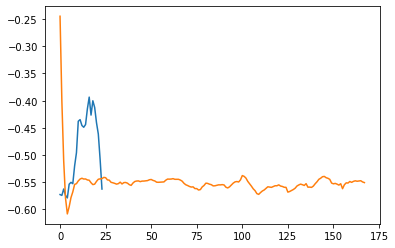

In [132]:
plt.plot(test_y[:24,0,0])
plt.plot(y_hat[0,:,0])
plt.show()